In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
^C
ERROR: Operation cancelled by user


In [1]:
import torch
import re
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
# from datasets import load_dataset
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import pandas as pd
import random
from torch.utils.data import DataLoader
import numpy as np
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

# Set seed for reproducibility
def set_seed_(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed_(42)
set_seed(42)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
!huggingface-cli login --token {hf_token}

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `llm_finetuning` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `llm_finetuning`


In [3]:
!nvidia-smi

Sat Aug 30 09:57:46 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.5     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:17:00.0 Off |                    0 |
| N/A   54C    P0              74W / 300W |   4151MiB / 81920MiB |     19%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
import os
print(os.getcwd())
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

/workspace/Assignment1/final_llm


In [5]:
import nltk
from nltk.corpus import treebank
import random


# Set random seed for reproducibility
random.seed(42)
# Make sure you have the corpora
nltk.download('treebank')
nltk.download('universal_tagset')


# Convert to list so we can sample
data = list(treebank.tagged_sents(tagset='universal'))

# print(f"Total sentences: {len(sentences)}")

# # Now sample 100
# gpt_test_sentences = random.sample(test_sentences, 100)

# print(f"Sampled {len(test_sentences)} sentences.")
# print("\nExample sentence:\n", test_sentences[0])


# import torch


# import nltk
# from nltk.corpus import brown
# import numpy as np
# from nltk.tag import map_tag
# from collections import defaultdict, Counter

# nltk.download('brown')
# nltk.download('universal_tagset')

start_tag = '^'

# data = brown.tagged_sents(tagset='universal')




tags = set(tag for sent in data for _, tag in sent)
sorted_tags = sorted(tags)
sorted_tags.append(start_tag)
print(tags)


sent_by_word = []
sent_by_tag = []
for sent in data:
    s = []
    t = []
    for word, tag in sent:
        s.append(word)
        t.append(tag)
    sent_by_word.append(s)
    sent_by_tag.append(t)
print(len(sent_by_word))
print(len(sent_by_tag))

data_X = sent_by_word
data_y = sent_by_tag



# words = [word for sent in data for word, tag in sent]
# words = set(words)
# vocab_size = len(words)
# print(vocab_size)


tag_to_idx = {c:i for i, c in enumerate(sorted_tags)}
idx_to_tag = {i:c for i, c in enumerate(sorted_tags)}





# from sklearn.model_selection import train_test_split

# # 80% train, 20% test
# X_train, X_test, y_train, y_test = train_test_split(
#     data_X, data_y, test_size=0.2, random_state=42, shuffle=True
# )

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


{'ADJ', 'X', 'ADP', 'PRT', 'NUM', 'NOUN', 'ADV', 'VERB', 'PRON', '.', 'DET', 'CONJ'}
3914
3914


In [ ]:
X_test = data_X
y_test = data_y
test_sentences = list(X_test)
original_labels = list(y_test)
original_sent_with_labels = [[(word, tag) for word, tag in zip(sent, tags)] 
                             for sent, tags in zip(test_sentences, original_labels)]# sentences_to_input_gpt = [[word for word, tag in sent] for sent in gpt_test_sentences]
import pandas as pd

# Prepare data
data = []
for sent, sent_labels in zip(test_sentences, original_sent_with_labels):
    data.append({
        "original_sentence": sent,        # List of words
        "ground_truth": sent_labels       # List of (word, tag) tuples
    })

# Create DataFrame
df = pd.DataFrame(data)

# Save to Excel
df.to_excel("penn_test_sentences_with_labels.xlsx", index=False)

print("Saved to 'penn_test_sentences_with_labels.xlsx'")

In [ ]:
import pandas as pd

# Read the Excel file
df = pd.read_excel("penn_test_sentences_with_labels.xlsx")

# Display the first 5 rows
print(df.head())

In [6]:
def inference(prompt, max_new_tokens=1024, temperature=0.3):
    """
    Helper function for inference
    ----------
    Parameters
    ----------
    prompt: string
    prompt for the generative model
    
    max_new_tokens: int
    Maximum number of token to be genearted 
    
    temperature: float
    temperature to parameterize the softmax
    ----------
    Returns the generated text
    """
    
    
    model_inputs = pos_tokenizer([prompt], return_tensors="pt").to(device_stereo)

    # For removal of input string from the output string
    input_ids_cutoff = model_inputs.input_ids.size(dim=1)
    
    generated_ids = pos_model.generate(**model_inputs,
                                   max_new_tokens=max_new_tokens,
                                   top_p = 1,
                                   temperature = temperature,
                                   do_sample=True, 
                                   pad_token_id=pos_tokenizer.eos_token_id)
    
    completion = pos_tokenizer.decode(
    generated_ids[0][input_ids_cutoff:],
    skip_special_tokens=True)
    
    return completion

In [7]:
from tqdm import tqdm

def get_pos_responses_with_one_shot(sentences, max_new_tokens=128):
    # Chain-of-Thought / one-shot prompt for POS tagging
    prompt_template = """
<s> [INST] You are a Part-of-Speech (POS) tagger.  
Your task is to assign **Universal POS tags** to each word in a given sentence.  
The Universal POS tagset is limited to the following categories:  
['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']  
</s> [/INST]

[INST]
### Instructions:
- Input will be a **list of words** (Python list format).  
- Output must be a Python **list of (word, tag) tuples**.  
- Use only the Universal POS tags listed above.  
- Punctuation such as `, . ? ! " `` ''` should be labeled as `'.'`.  
- Proper nouns (names, places, organizations) should be tagged as `NOUN`.  
- Words not fitting any category should be tagged as `X`.  

### Example:
Input: ['The', 'cat', 'sat', 'on', 'the', 'mat', '.']  
Output: [('The', 'DET'), ('cat', 'NOUN'), ('sat', 'VERB'), ('on', 'ADP'), ('the', 'DET'), ('mat', 'NOUN'), ('.', '.')]

### Now tag the following sentence:
Input: {sentence}
Output:
[/INST]
"""

    # Wrap each sentence in the prompt
    messages = [[prompt_template.format(sentence=sentence)] for sentence in sentences]
    
    responses = []
    for i in tqdm(range(len(messages))):
        responses.append(inference(messages[i][0], max_new_tokens=max_new_tokens))
        
    return responses

In [30]:
sentences = []
sents = ["Time flies like an arrow."]
for sentence in sents:
    sentences.append(re.findall(r"\w+|[^\w\s]", sentence))


In [31]:
responses = get_pos_responses_with_one_shot(sentences, max_new_tokens=128)

print(responses)

100%|█████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

["[('Time', 'NOUN'), ('flies', 'VERB'), ('like', 'ADP'), ('an', 'DET'), ('arrow', 'NOUN'), ('.', '.')]"]


In [32]:
import ast

# Convert string to list of tuples
word_tag_list = ast.literal_eval(responses[0])

# Find max width for formatting
word_width = max(len(word) for word, _ in word_tag_list)
tag_width = max(len(tag) for _, tag in word_tag_list)

# Print header
print(f"+{'-'*(word_width+2)}+{'-'*(tag_width+2)}+")
print(f"| {'Word':<{word_width}} | {'POS Tag':<{tag_width}} |")
print(f"+{'-'*(word_width+2)}+{'-'*(tag_width+2)}+")

# Print rows
for word, tag in word_tag_list:
    print(f"| {word:<{word_width}} | {tag:<{tag_width}} |")

# Print footer
print(f"+{'-'*(word_width+2)}+{'-'*(tag_width+2)}+")

+-------+------+
| Word  | POS Tag |
+-------+------+
| Time  | NOUN |
| flies | VERB |
| like  | ADP  |
| an    | DET  |
| arrow | NOUN |
| .     | .    |
+-------+------+


In [18]:
!pip install tabulate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


NameError: name 'tabulate' is not defined

In [8]:
sentences = list(df['original_sentence'])
print(len(sentences))

NameError: name 'df' is not defined

In [ ]:
import pandas as pd
import ast  # for safely parsing string representations

# Suppose you already have:
# sentences = [...]  # your input sentences
# responses = [...]  # list of strings like ["[('Open', 'ADJ'), ...]", ...]

responses = get_pos_responses_with_one_shot(sentences, max_new_tokens=128)
df['original_response_mistral'] = responses

# Save to Excel
df.to_excel("original_mistral_responses.xlsx", index=False)

print("Saved responses to original_mistral_responses.xlsx")


In [ ]:
import os
print(os.getcwd())

In [ ]:
# Convert string responses to actual list of tuples
parsed_responses = [ast.literal_eval(resp) for resp in responses]
df['parsed_response_mistral'] = parsed_responses

# Save to Excel
df.to_excel("mistral_responses.xlsx", index=False)

print("Saved responses to mistral_responses.xlsx")

In [ ]:
# !pip install sentencepiece

In [11]:
# Load the first causal LM for pos tagging
pos_model_name = 'mistralai/Mistral-7B-Instruct-v0.3'

pos_model = AutoModelForCausalLM.from_pretrained(pos_model_name)
pos_tokenizer = AutoTokenizer.from_pretrained(pos_model_name)
pos_tokenizer.padding_side='left'

Loading checkpoint shards: 100%|██████████████| 3/3 [00:04<00:00,  1.51s/it]


In [12]:
# Ensure pad_token_id is set to eos_token_id if not already set
if pos_tokenizer.pad_token_id is None:
    pos_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    pos_model.resize_token_embeddings(len(pos_tokenizer))


device_stereo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pos_model.to(device_stereo)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32769, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): MistralRMSNorm((4096,), eps=1e-0

In [ ]:
print(device_stereo)

In [28]:
import ast
import re

# This approach had to be implemented, as we received half-outputs of POS tags for few sentences
# Mistral exited before waiting to receive the complete answer
def safe_parse_pairs(text):
    if pd.isna(text):
        return []
    
    pattern = r"\('([^']+)',\s*'([^']+)'\)"
    pairs = re.findall(pattern, text)
    
    return pairs

def clean_string(s):
    # Replace double double-quotes with single double-quote
    s = s.replace('""', '"')
    # Replace curly quotes with straight quotes
    s = s.replace('“', '"').replace('”', '"').replace("‘", "'").replace("’", "'")
    # Remove any leading/trailing whitespace
    s = s.strip()
    s = s.replace('``', '')
    return s

In [29]:
import pandas as pd

df = pd.read_excel('original_mistral_responses.xlsx')

df["gt_pairs"] = df["ground_truth"].apply(clean_string).apply(safe_parse_pairs)
df["mistral_pairs"] = df["original_response_mistral"].apply(clean_string).apply(safe_parse_pairs)

In [30]:
import nltk
from nltk.corpus import treebank
import random

random.seed(42)
nltk.download('treebank')
nltk.download('universal_tagset')

data = list(treebank.tagged_sents(tagset='universal'))

tags = set(tag for sent in data for _, tag in sent)
sorted_tags = sorted(tags)

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [31]:
sorted_tags

['.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X']

In [32]:
all_tags = set(tag for row in df["gt_pairs"] for _, tag in row)
print(all_tags)

{'PRT', 'NOUN', 'CONJ', 'DET', 'X', 'NUM', '.', 'PRON', 'ADP', 'ADV', 'VERB', 'ADJ'}


In [33]:
all_tags = set(tag for row in df["mistral_pairs"] for _, tag in row)
print(all_tags)

{'PRT', 'X', 'TO', '.', 'SUBORD', 'ADP-ADJ', 'PROPN', 'VBD', 'ADV', 'PRP$', 'ADJ', 'PLURAL_NOUN', 'WRB', 'ADT', 'DET', 'ADR', 'NUM', 'CURRENCY', 'WDT', 'AUX', 'JJ', 'CCONJ', 'SUB', 'DT', 'MOD', 'Noun', 'PLN', 'PREP', 'NOUN', 'MD', 'CARD', 'ADP', ':', 'SCONJ', 'ART', 'CUR', 'SYM', 'VERB-PART', 'WPRT', 'CONJ', 'CD', 'WHNP', 'PRON', 'DAY', 'ADW', 'PRP', ',', 'PUNCT', 'IN', 'PRO', 'VERB'}


In [34]:
# Universal POS tagset
universal_tags = ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 
                  'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']

# Mapping from messy tags → universal
tag_map = {
    "NOUN": "NOUN", "Noun": "NOUN", "PLURAL_NOUN": "NOUN", "PROPN": "NOUN",
    "PRP": "PRON", "PRP$": "PRON", "PRO": "PRON", 
    "DT": "DET", "DET": "DET", "ART": "DET", "WDT": "DET", "WHNP": "DET",
    "JJ": "ADJ", "ADJ": "ADJ", "ADT": "ADJ",
    "ADV": "ADV", "ADW": "ADV", "WRB": "ADV",
    "VERB": "VERB", "VBD": "VERB", "AUX": "VERB", "MD": "VERB", "MOD": "VERB", 
    "VERB-PART": "VERB",
    "PRT": "PRT", "TO": "PRT",
    "CONJ": "CONJ", "CCONJ": "CONJ", "SCONJ": "CONJ", "SUBORD": "CONJ", "SUB": "CONJ",
    "CD": "NUM", "NUM": "NUM", "CARD": "NUM", "DAY": "NUM", "CUR": "NUM", "CURRENCY": "NUM", "PLN": "NUM",
    "ADP": "ADP", "IN": "ADP", "PREP": "ADP", "ADP-ADJ": "ADP", "ADR": "ADP",
    "PUNCT": ".", ".": ".", ",": ".", ":": ".",
    "SYM": "X", "X": "X"
}


In [35]:
def map_to_universal(tag):
    return tag_map.get(tag, "X")

df["mistral_universal"] = df["mistral_pairs"].apply(
    lambda pairs: [(w, map_to_universal(t)) for w, t in pairs]
)

In [36]:
all_tags = set(tag for row in df["mistral_universal"] for _, tag in row)
print(all_tags)

{'PRT', 'NOUN', 'CONJ', 'DET', 'X', 'NUM', '.', 'PRON', 'ADP', 'ADV', 'VERB', 'ADJ'}


In [37]:
actual_tags = []
tag_predicted = []

In [38]:
correct = 0
total = 0
num_word_mismatch = 0

for idx, row in df.iterrows():
    ground_truth = row['gt_pairs']
    mistral_answer = row['mistral_universal']

    for (or_word, or_tag), (mistral_word, mistral_tag) in zip(ground_truth, mistral_answer):
        if or_word == mistral_word:
            actual_tags.append(or_tag)
            tag_predicted.append(mistral_tag)
            if or_tag == mistral_tag:
                correct += 1
        else:
            num_word_mismatch += 1
            continue
        total += 1

accuracy = 100*(correct / total) if total > 0 else 0
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 83.64%


### Mistral LLM Analysis (Penn Dataset)

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(actual_tags, tag_predicted)
precision = precision_score(actual_tags, tag_predicted, average="weighted")
recall = recall_score(actual_tags, tag_predicted, average="weighted")
f1 = f1_score(actual_tags, tag_predicted, average="weighted")

print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")

Accuracy : 0.84
Precision: 0.86
Recall   : 0.84
F1 Score : 0.83


In [25]:
from sklearn.metrics import classification_report
print(classification_report(actual_tags, tag_predicted))

              precision    recall  f1-score   support

           .       0.95      0.93      0.94      4467
         ADJ       0.85      0.59      0.70      3586
         ADP       0.81      0.80      0.81      5506
         ADV       0.60      0.87      0.71      1707
        CONJ       0.59      0.96      0.73      1163
         DET       0.97      0.88      0.92      5299
        NOUN       0.96      0.91      0.94     16381
         NUM       0.63      0.92      0.75      1777
        PRON       0.85      0.02      0.03      1668
         PRT       0.19      0.11      0.14      1206
        VERB       0.95      0.97      0.96      8136
           X       0.49      0.81      0.62      3178

    accuracy                           0.84     54074
   macro avg       0.74      0.73      0.69     54074
weighted avg       0.86      0.84      0.83     54074



### Per-POS Confusion Matrix

In [26]:
from sklearn.metrics import confusion_matrix

labels = sorted_tags
cm = confusion_matrix(actual_tags, tag_predicted, labels=labels)

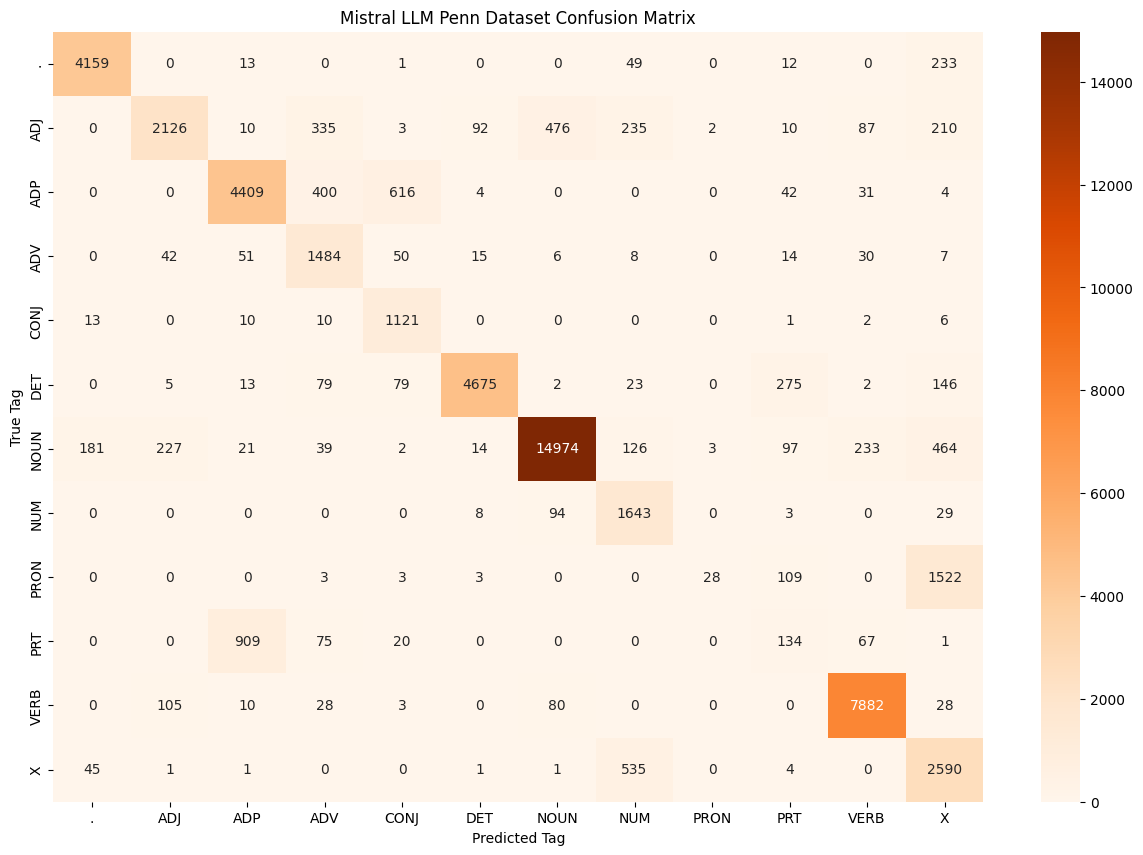

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Tag")
plt.ylabel("True Tag")
plt.title("Mistral LLM Penn Dataset Confusion Matrix")
plt.show()